In [1]:
import h5py
file_path = '/home/balarcon/Documentos/exams_part0.hdf5'
with h5py.File(file_path, 'r') as f:
    for name, dataset in f.items():
        print(f"Dataset: {name}")
        print(f"Shape: {dataset.shape}")
        print(f"Data type: {dataset.dtype}")
        for key, value in dataset.attrs.items():
            print(f"Attribute: {key}, Value: {value}")

Dataset: exam_id
Shape: (20001,)
Data type: int64
Dataset: tracings
Shape: (20001, 4096, 12)
Data type: float32


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, TimeDistributed 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-06-06 13:47:40.424499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 13:47:44.666729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Enable dynamic memory allocation for TensorFlow
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Get list of available GPUs
gpus = tf.config.list_physical_devices('GPU')
num_gpus = len(gpus)

print(f"Num GPUs Available: {num_gpus}")

# Enable memory growth for each GPU
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

Num GPUs Available: 1


In [4]:
# Define input and output leads
input_leads = [0, 1, 7]  # DI, DII, V2
output_leads = [2, 3, 4, 5, 6, 8, 9, 10, 11]  # DIII, AVR, AVL, AVF, V1, V3, V4, V5, V6

# Data Generator
class HDF5Generator(tf.keras.utils.Sequence):
    def __init__(self, file_path, dataset_name, indices, batch_size):
        self.file_path = file_path
        self.dataset_name = dataset_name
        self.indices = np.sort(indices)
        self.batch_size = batch_size
        self.num_samples = len(indices)
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.scalers_fitted = False  

    def fit_scalers(self):
        with h5py.File(self.file_path, 'r') as f:
            dataset = f[self.dataset_name]
            X_list = []
            y_list = []
            for idx in self.indices[:100]:  # Use a small subset for fitting scalers
                X_list.append(dataset[idx, 1024:3072, input_leads])
                y_list.append(dataset[idx, 1024:3072, output_leads])
            X_sample = np.array(X_list)
            y_sample = np.array(y_list)
            self.scaler_X.fit(X_sample.reshape(-1, len(input_leads)))
            self.scaler_y.fit(y_sample.reshape(-1, len(output_leads)))
            self.scalers_fitted = True  # Mark scalers as fitted

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, idx):
        if not self.scalers_fitted:
            self.fit_scalers()  # Fit scalers if not done already

        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, self.num_samples)
        batch_indices = self.indices[batch_start:batch_end]

        with h5py.File(self.file_path, 'r') as f:
            dataset = f[self.dataset_name]
            batch_X = [dataset[idx, 1024:3072, input_leads] for idx in batch_indices]
            batch_y = [dataset[idx, 1024:3072, output_leads] for idx in batch_indices]

        batch_X = np.array(batch_X)
        batch_y = np.array(batch_y)

        batch_X = self.scaler_X.transform(batch_X.reshape(-1, len(input_leads))).reshape(batch_X.shape)
        batch_y = self.scaler_y.transform(batch_y.reshape(-1, len(output_leads))).reshape(batch_y.shape)

        return batch_X, batch_y

In [15]:
batch_size = 64
subset_size = 1000  

# Split indices for training and validation
with h5py.File(file_path, 'r') as f:
    total_samples = f['tracings'].shape[0]
indices = np.arange(total_samples)
selected_indices = np.random.choice(indices, subset_size, replace=False)
train_indices, val_indices = train_test_split(selected_indices, test_size=0.2, random_state=42)

# Initialize generators
train_generator = HDF5Generator(file_path, 'tracings', train_indices, batch_size)
val_generator = HDF5Generator(file_path, 'tracings', val_indices, batch_size)

In [16]:
# Define the model
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(len(output_leads), activation='linear')))
    return model

# Initialize the model
input_shape = (2048, len(input_leads))  # Adjust input_shape based on your data
model = build_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 2048, 128)         34816     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 2048, 128)         0         
                                                                 
 time_distributed_2 (TimeDi  (None, 2048, 9)           1161      
 stributed)                                                      
                                                                 
Total params: 35977 (140.54 KB)
Trainable params: 35977 (140.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
13/13 [==============================] - 10s 536ms/step - loss: 1.0013 - mae: 0.4861 - val_loss: 0.6789 - val_mae: 0.4177
Epoch 2/30
13/13 [==============================] - 2s 132ms/step - loss: 0.7388 - mae: 0.3854 - val_loss: 0.5336 - val_mae: 0.3555
Epoch 3/30
13/13 [==============================] - 2s 130ms/step - loss: 0.6308 - mae: 0.3487 - val_loss: 0.4890 - val_mae: 0.3473
Epoch 4/30
13/13 [==============================] - 3s 211ms/step - loss: 0.5789 - mae: 0.3281 - val_loss: 0.4623 - val_mae: 0.3289
Epoch 5/30
13/13 [==============================] - 2s 137ms/step - loss: 0.5494 - mae: 0.3141 - val_loss: 0.4490 - val_mae: 0.3213
Epoch 6/30
13/13 [==============================] - 2s 129ms/step - loss: 0.5256 - mae: 0.3025 - val_loss: 0.4457 - val_mae: 0.3199
Epoch 7/30
13/13 [==============================] - 2s 129ms/step - loss: 0.5089 - mae: 0.2949 - val_loss: 0.4376 - val_mae: 0.3116
Epoch 8/30
13/13 [==============================] - 3s 223ms/step - loss: 0

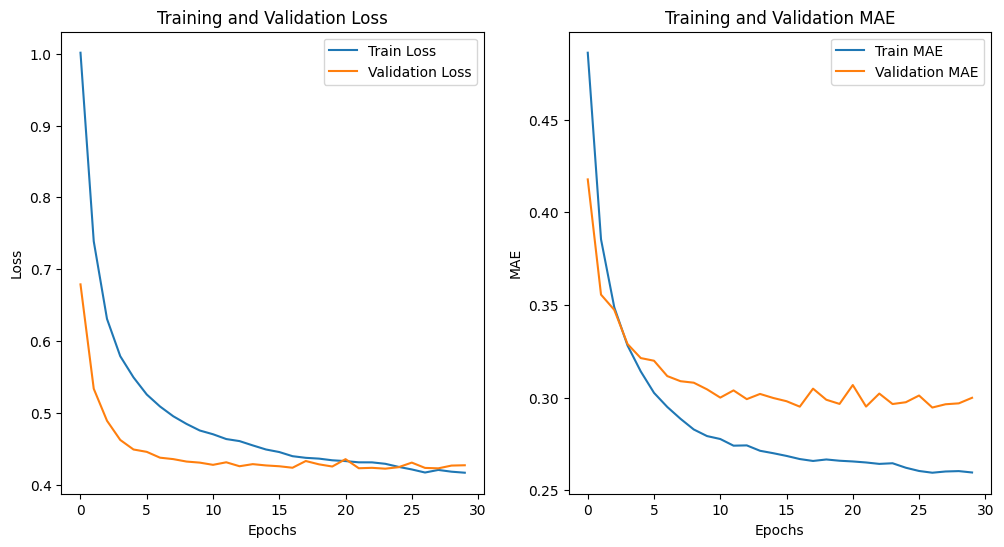

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')

    plt.show()

plot_history(history)

4/4 [==============================] - 0s 56ms/step - loss: 0.4270 - mae: 0.2999
Validation Loss: 0.4270
Validation MAE: 0.2999
2/2 [==============================] - 0s 44ms/step


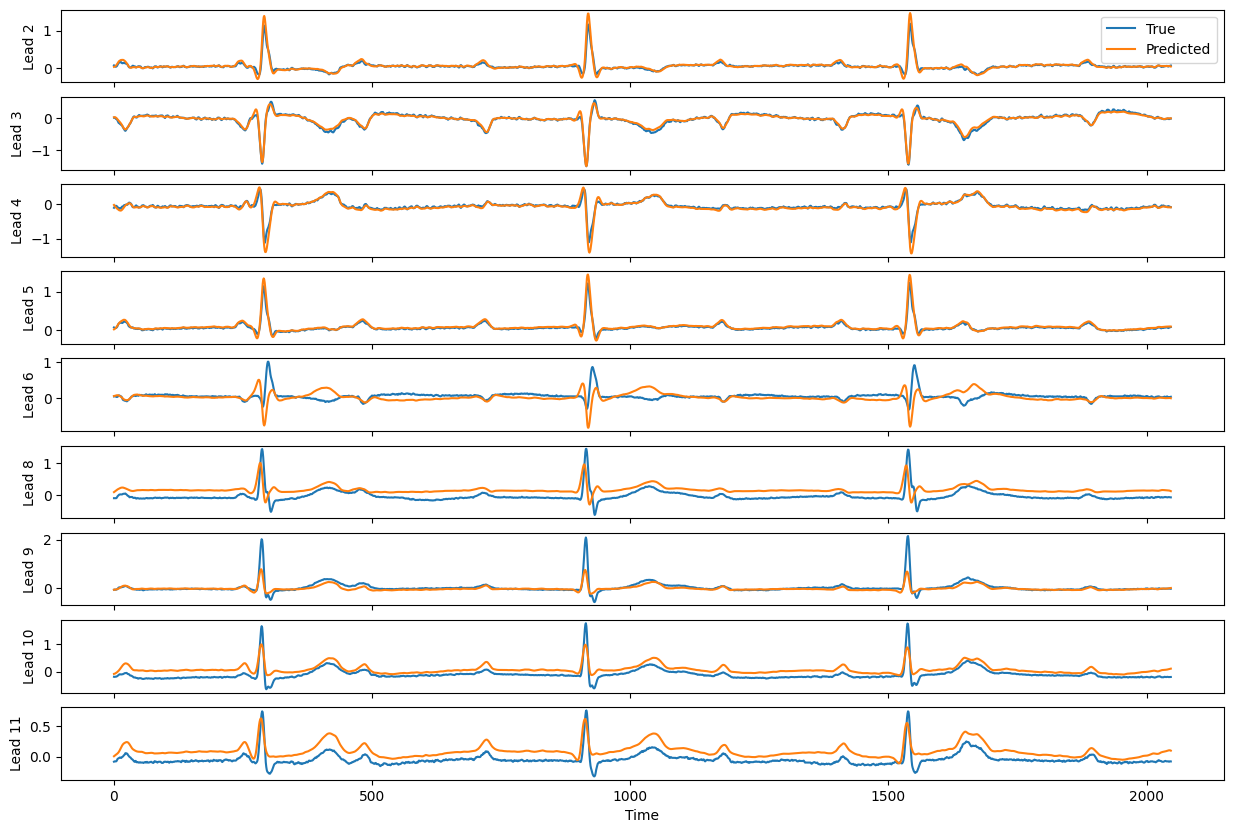

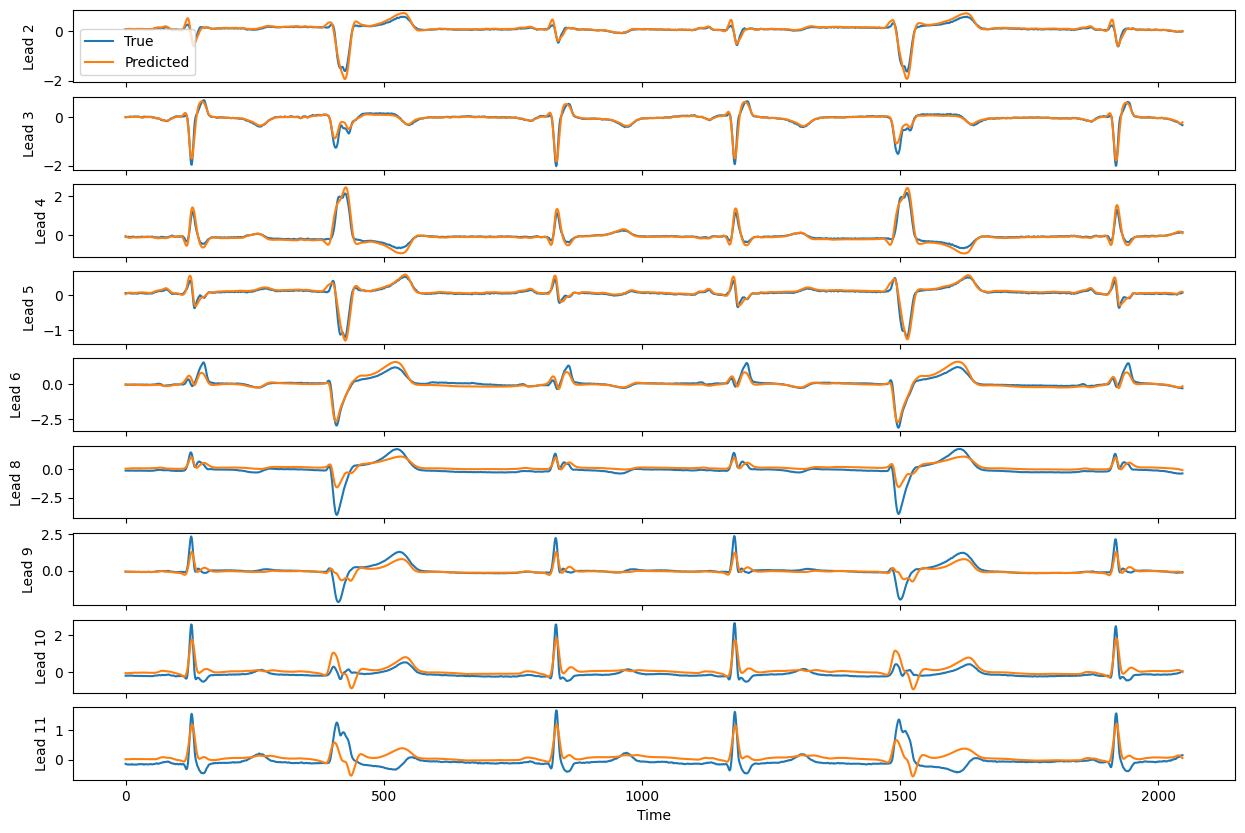

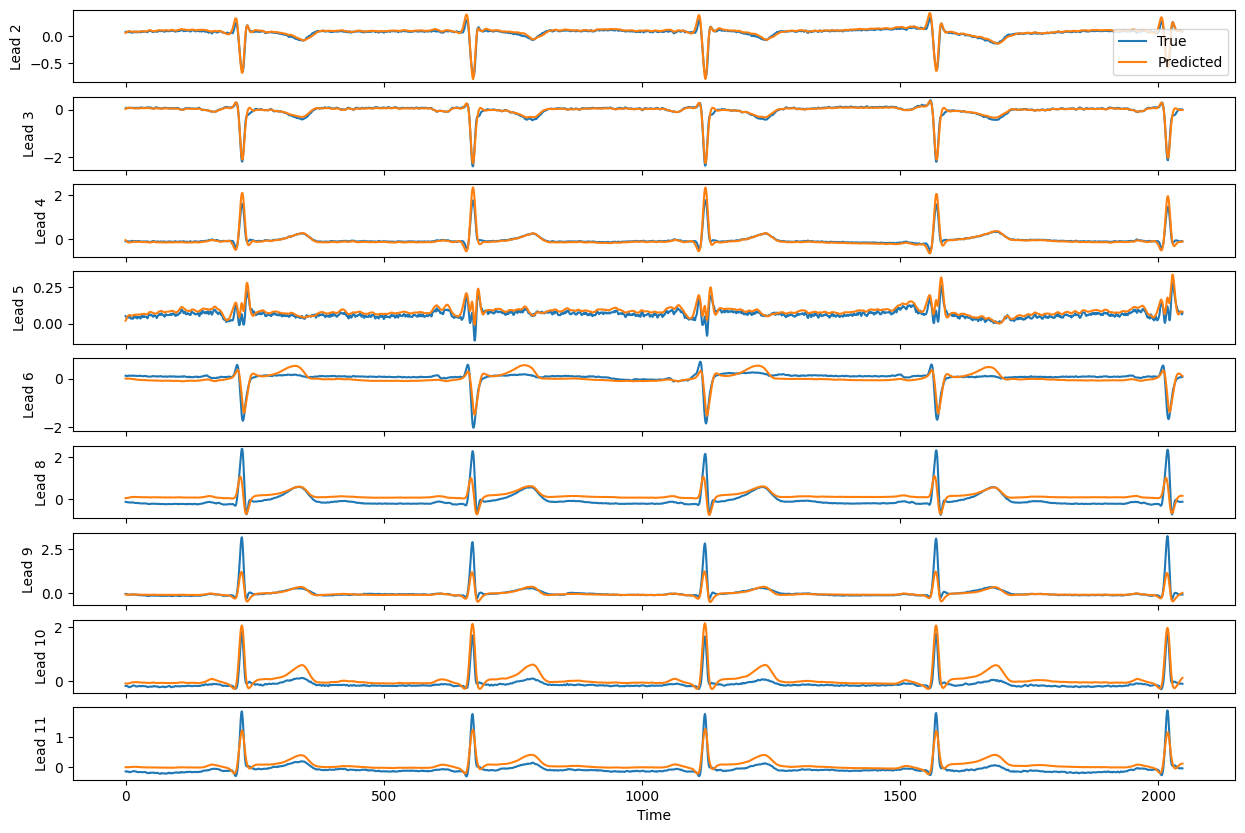

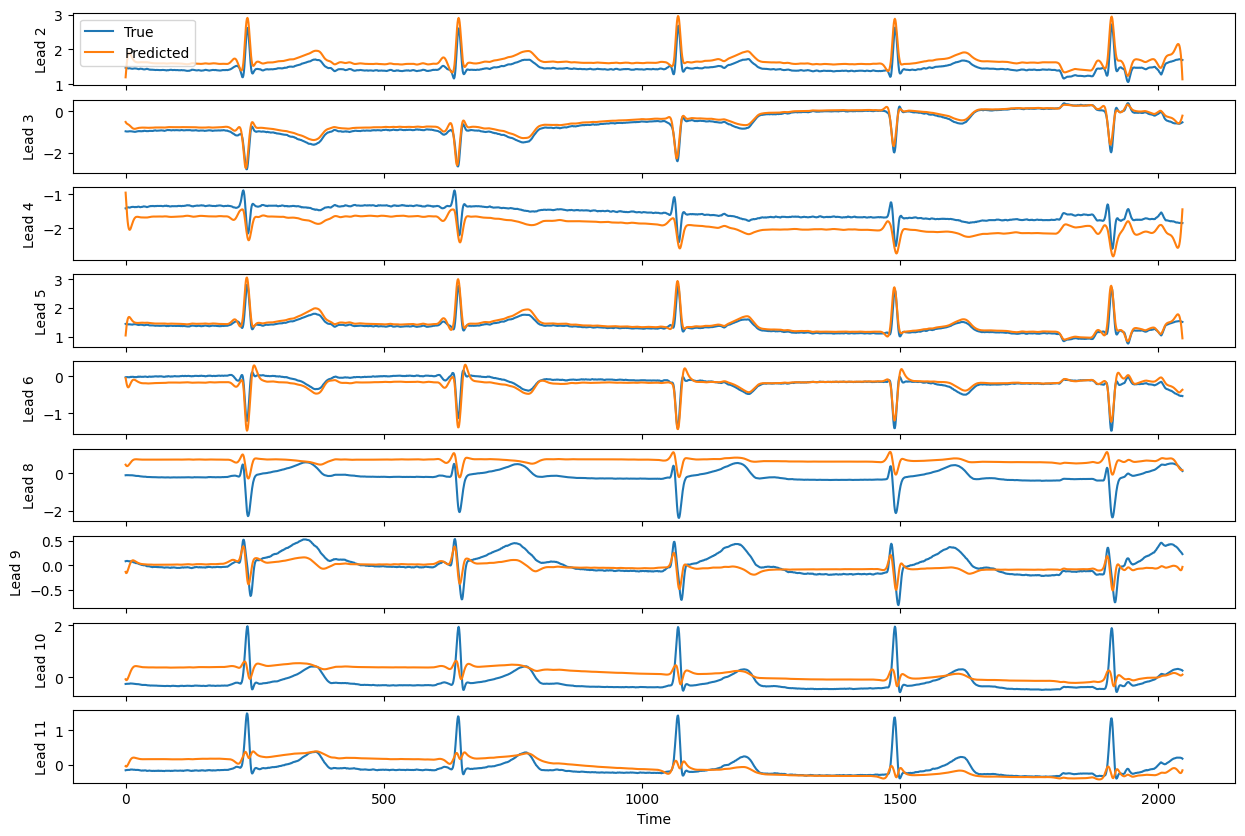

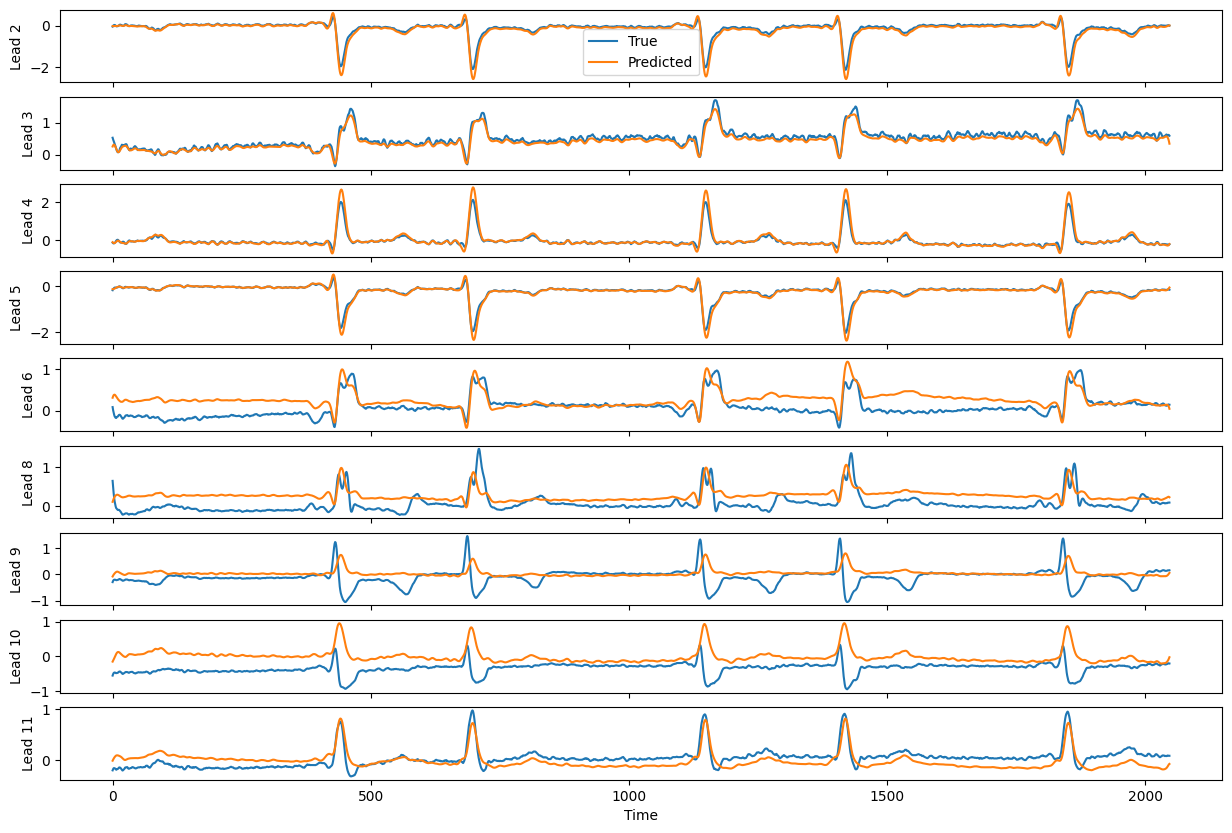

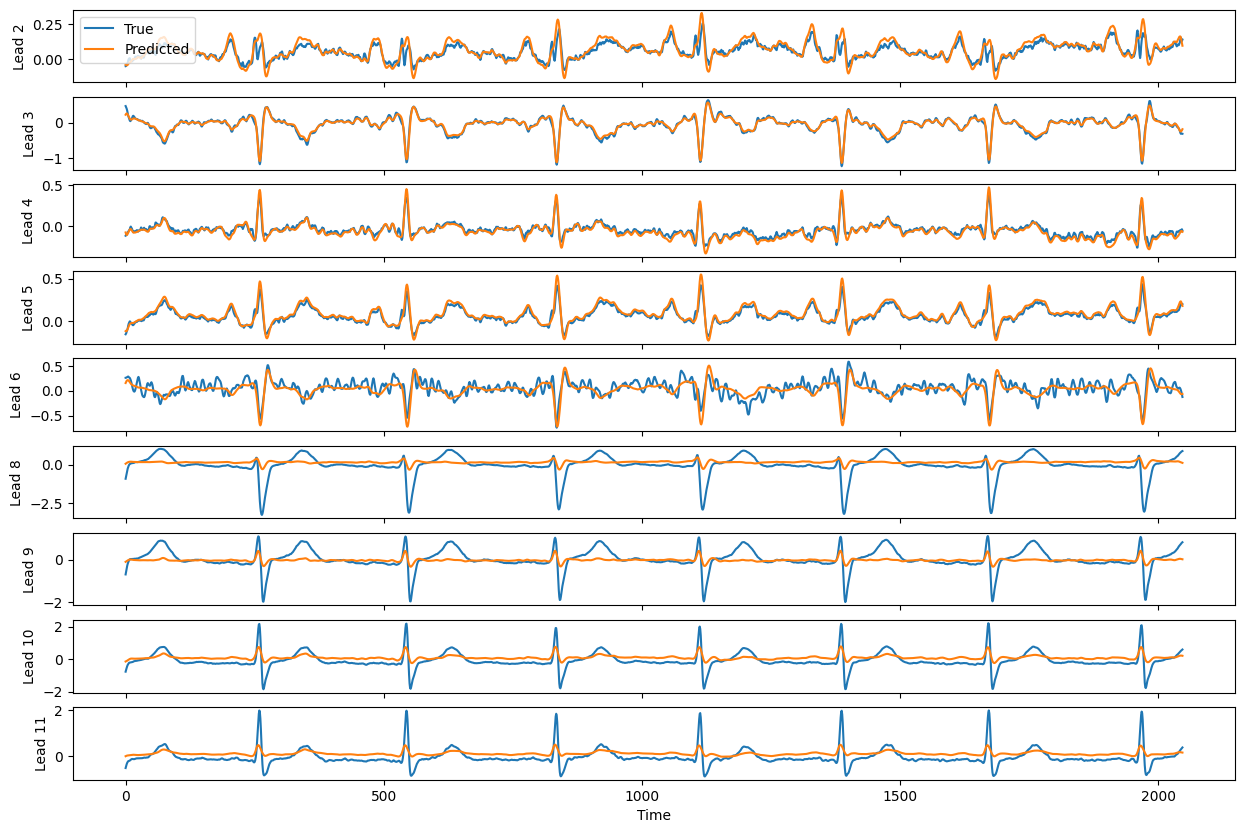

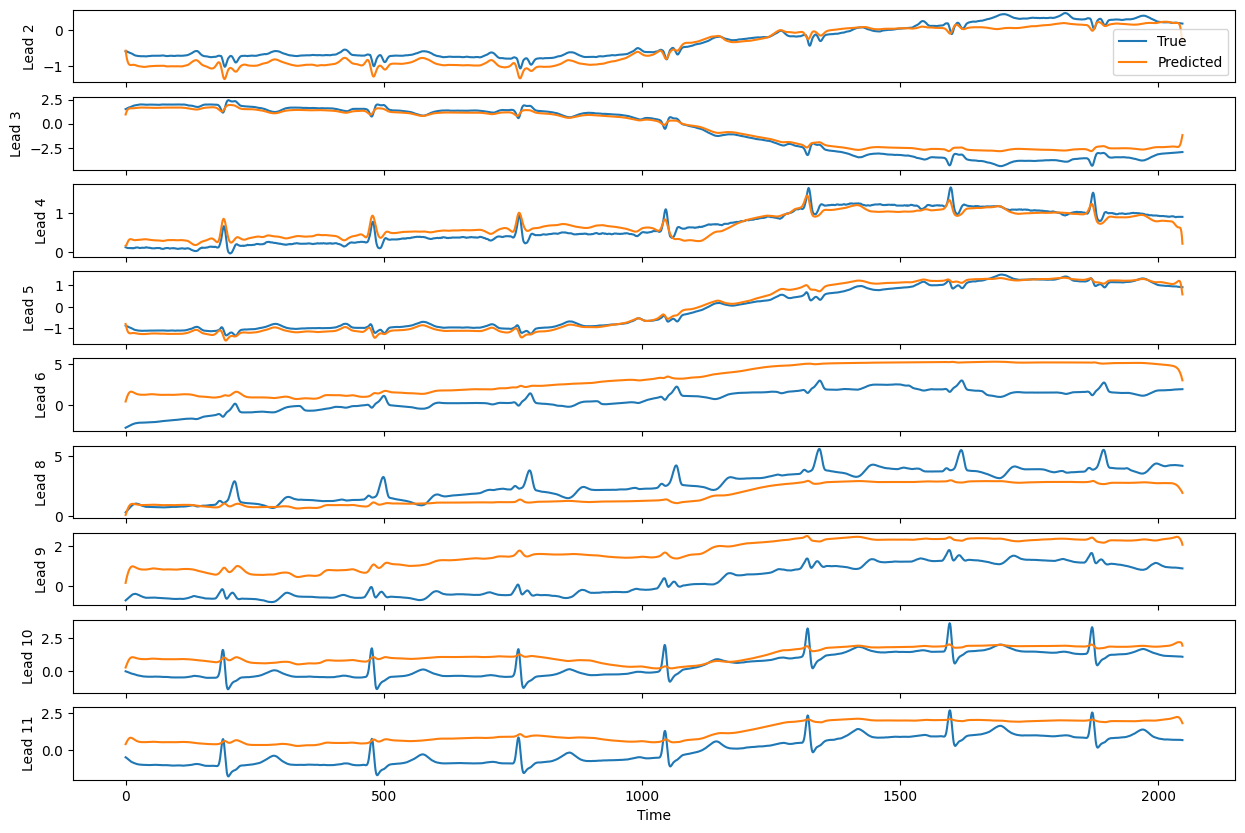

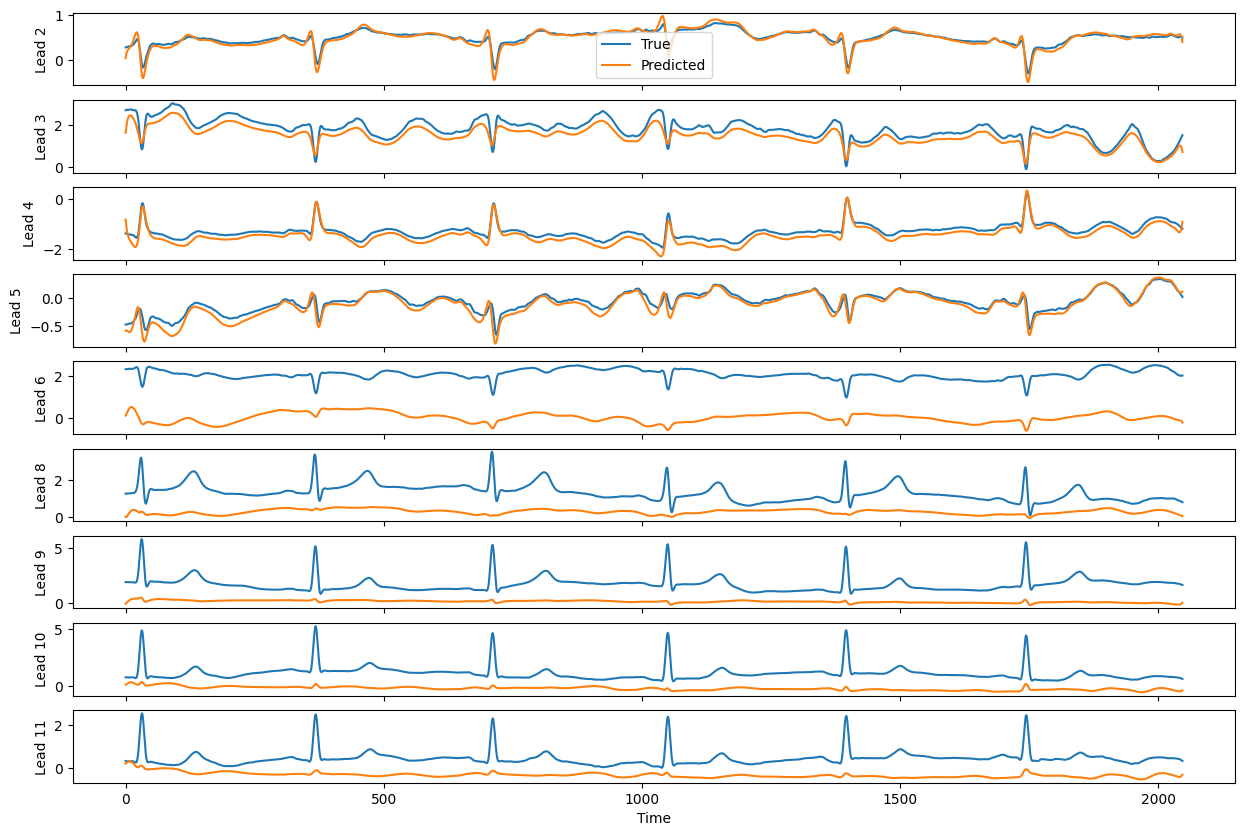

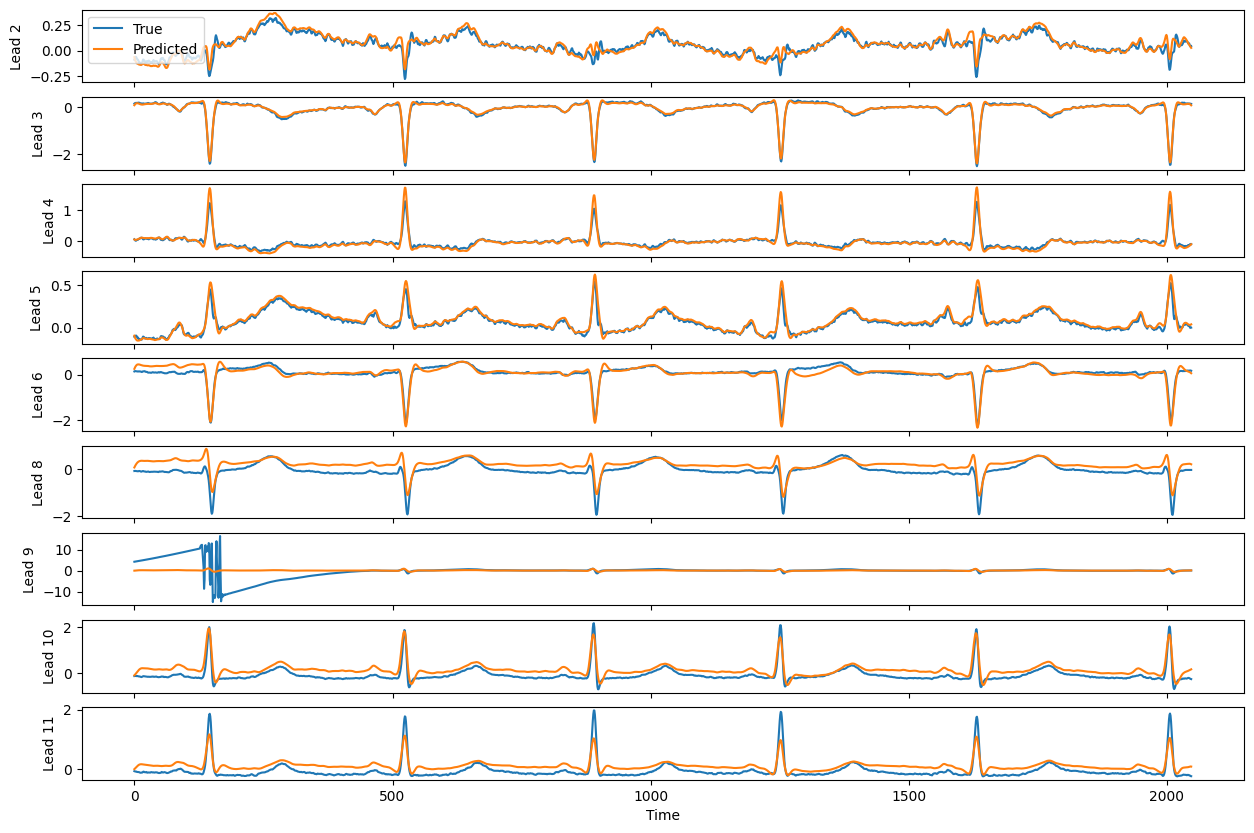

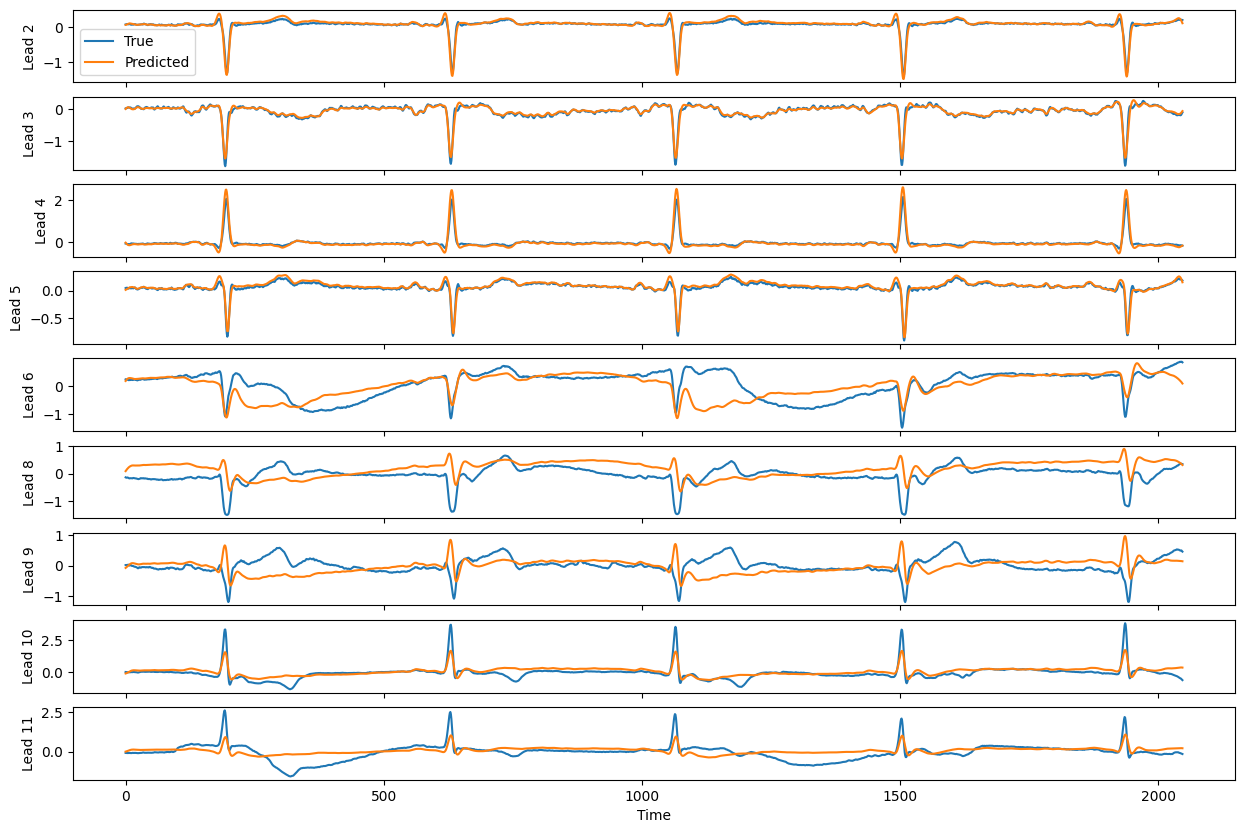

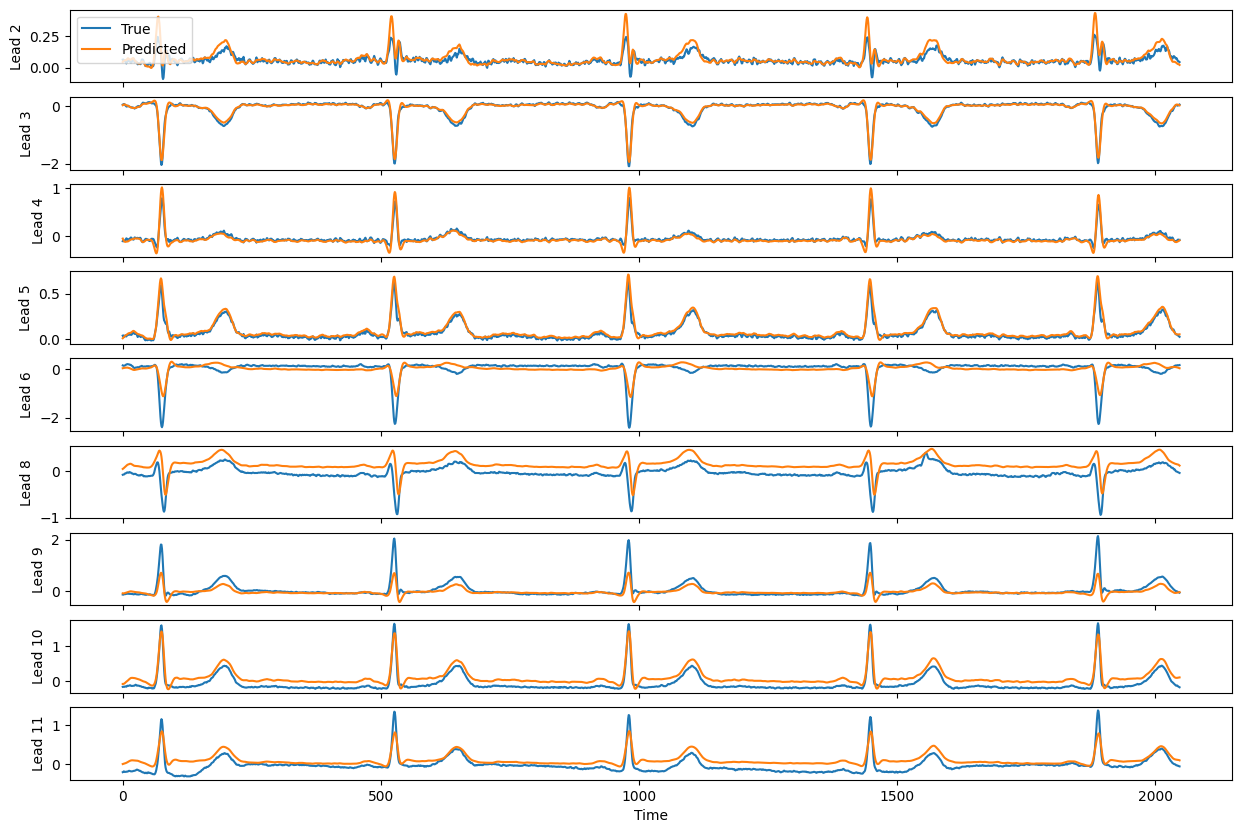

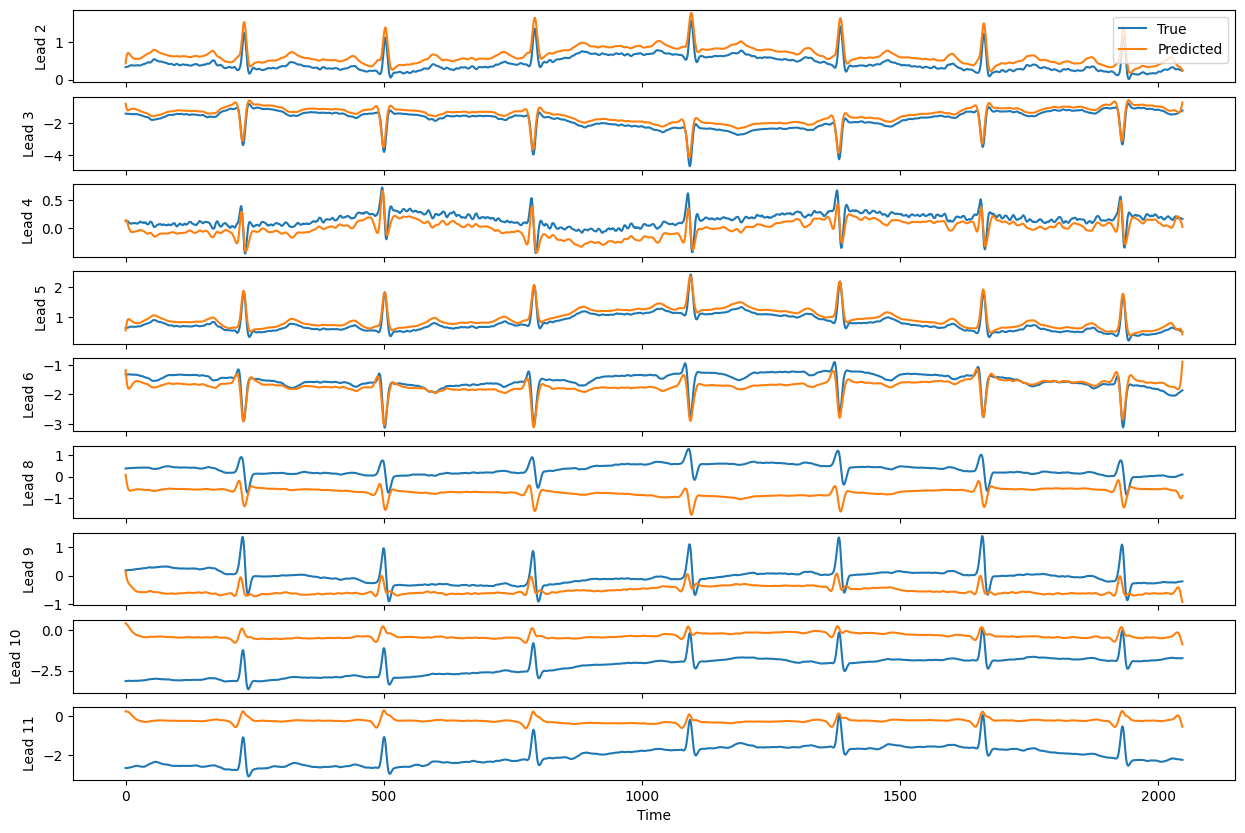

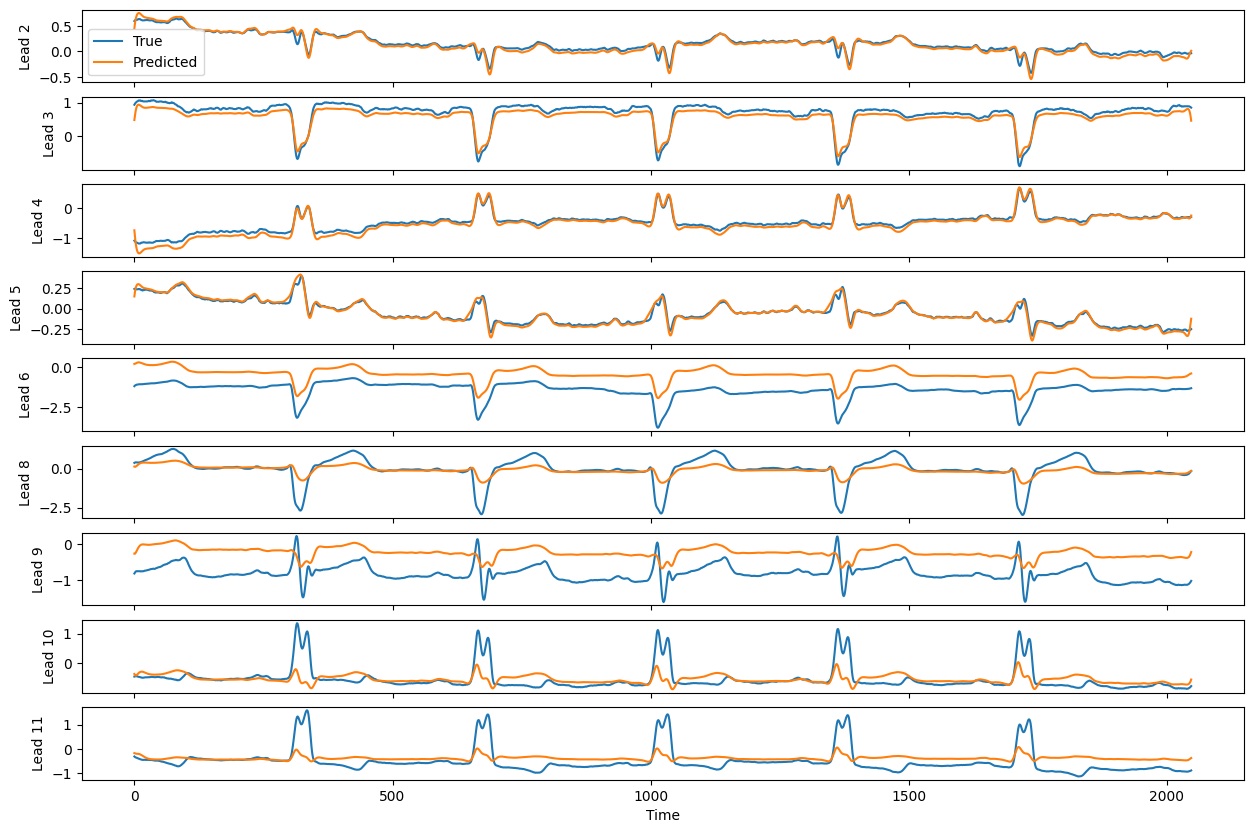

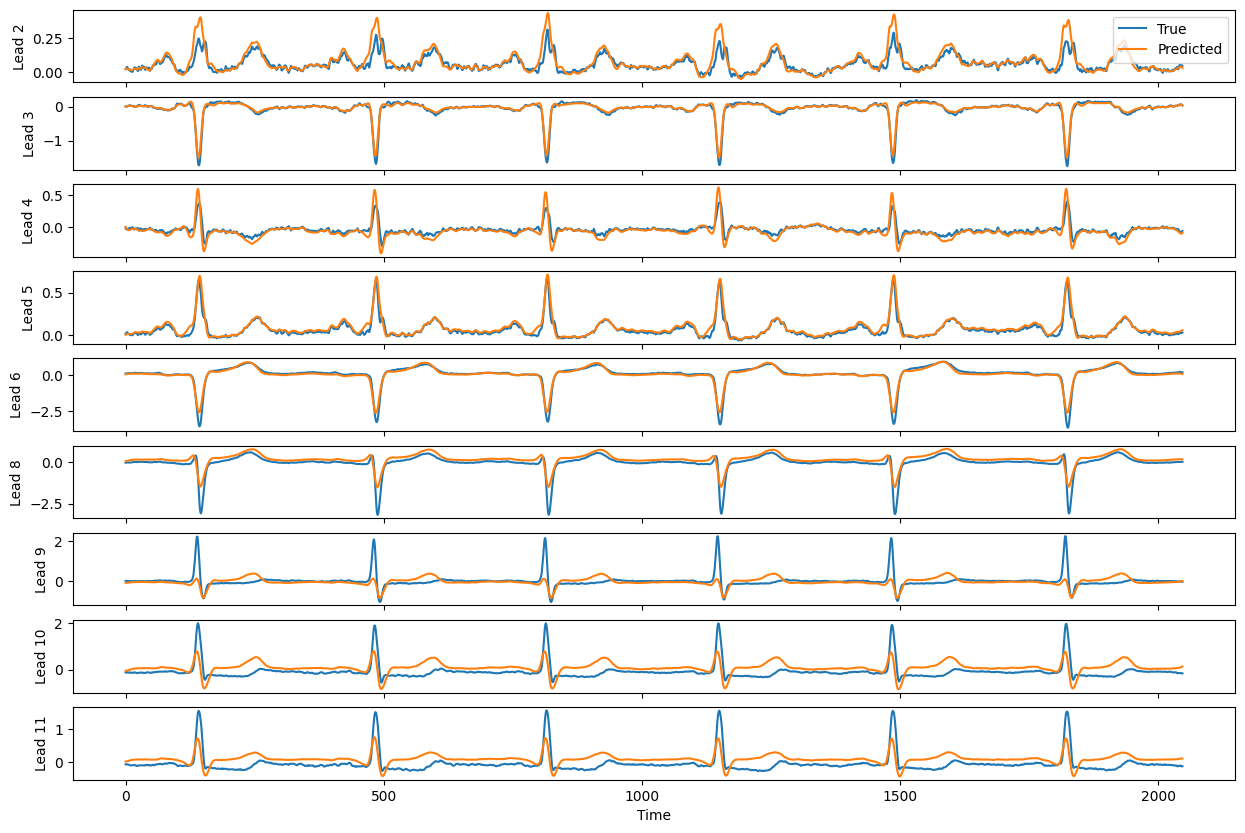

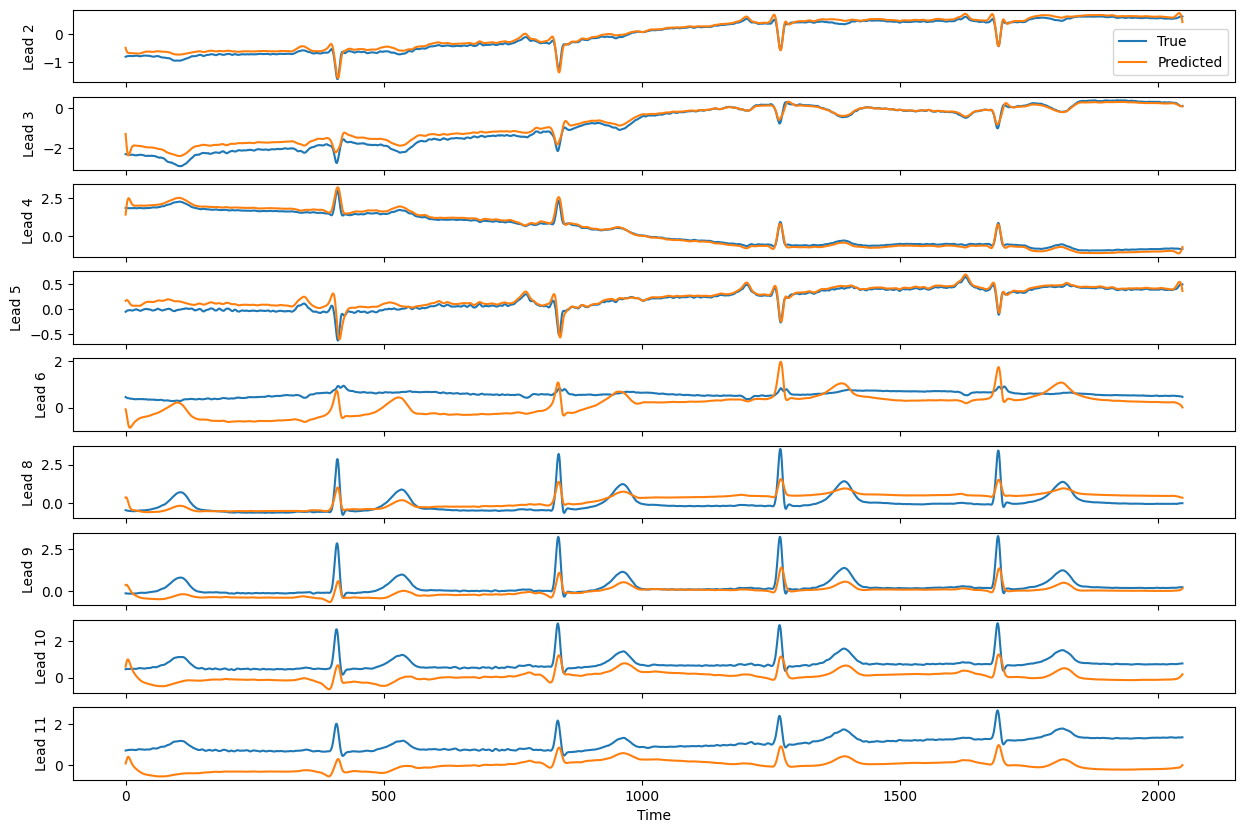

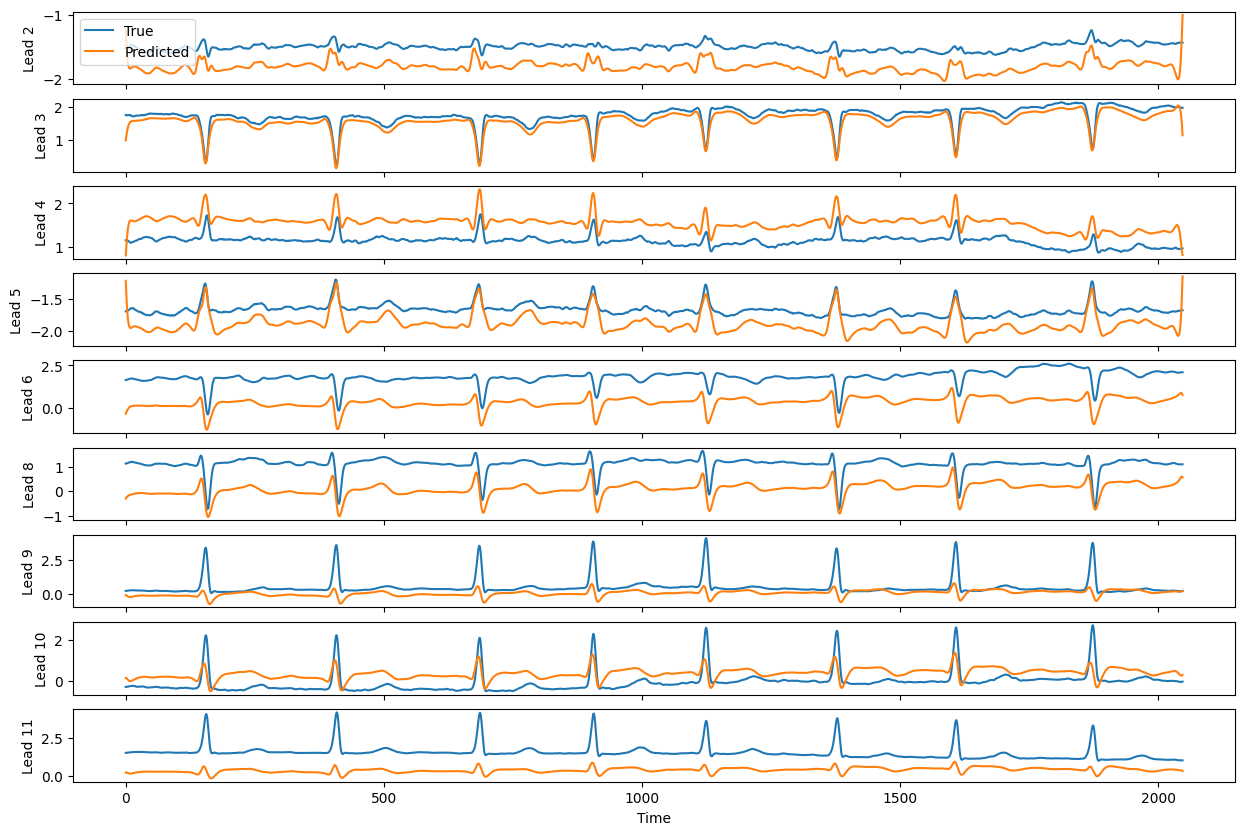

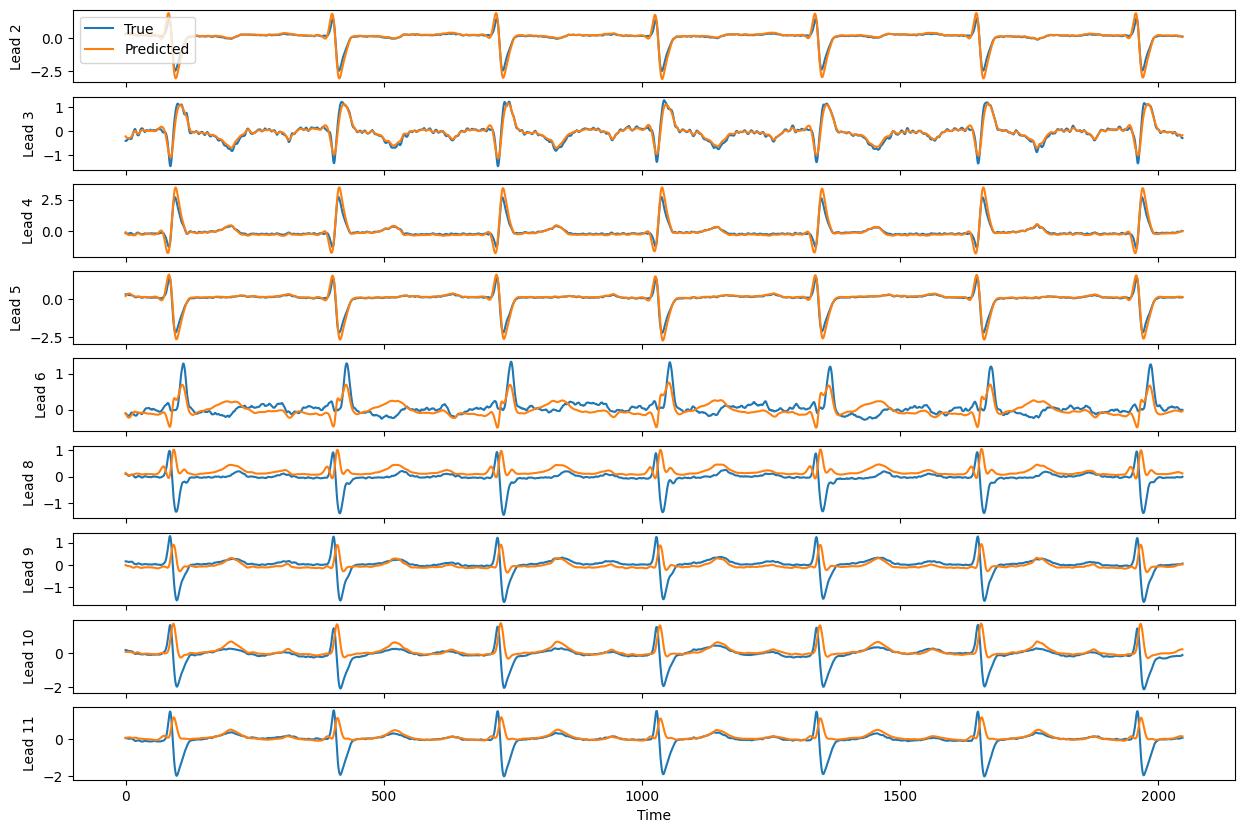

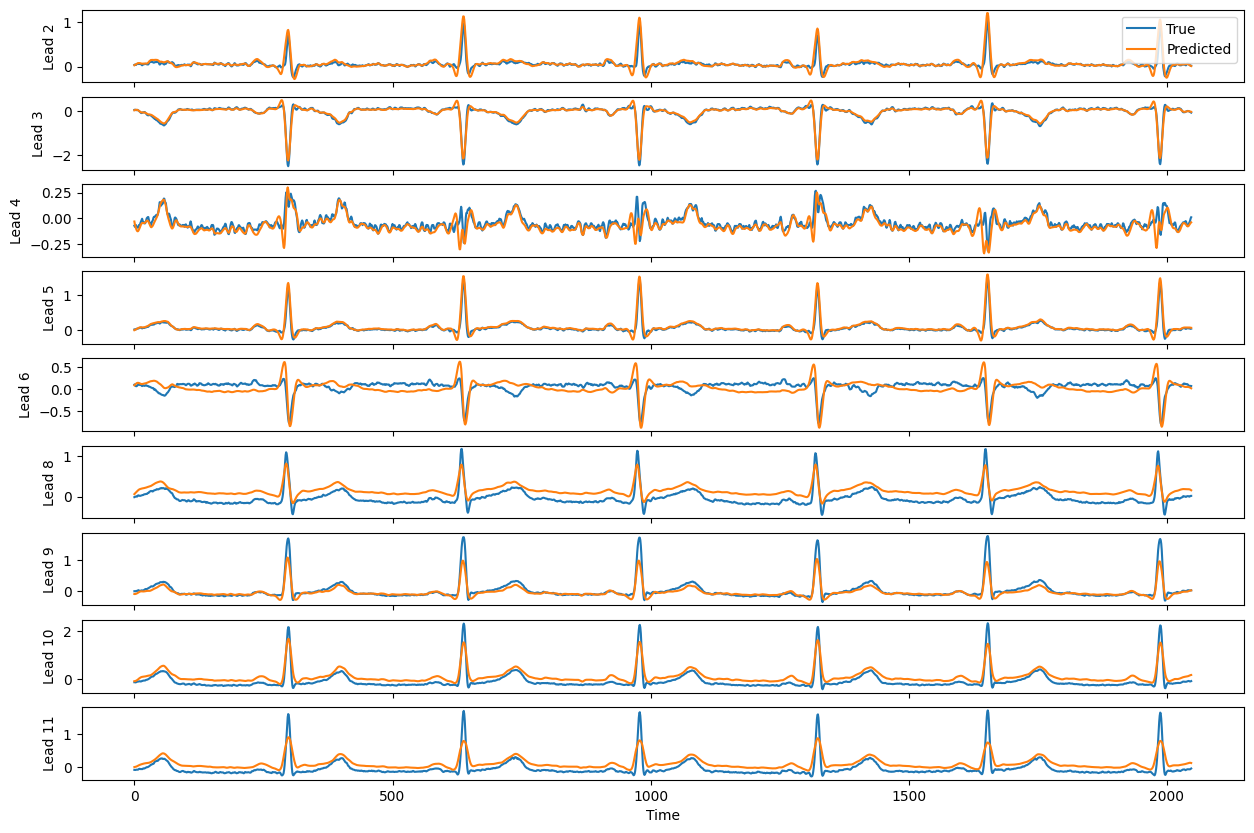

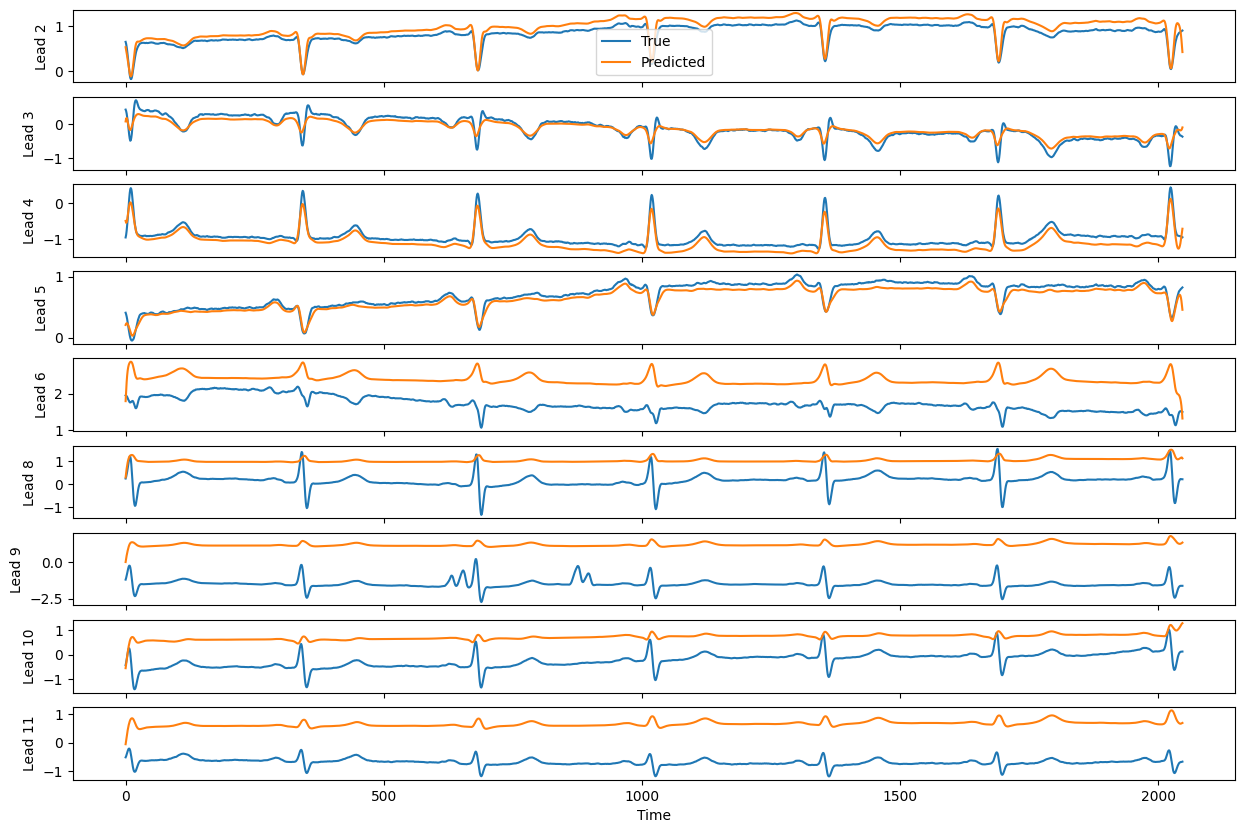

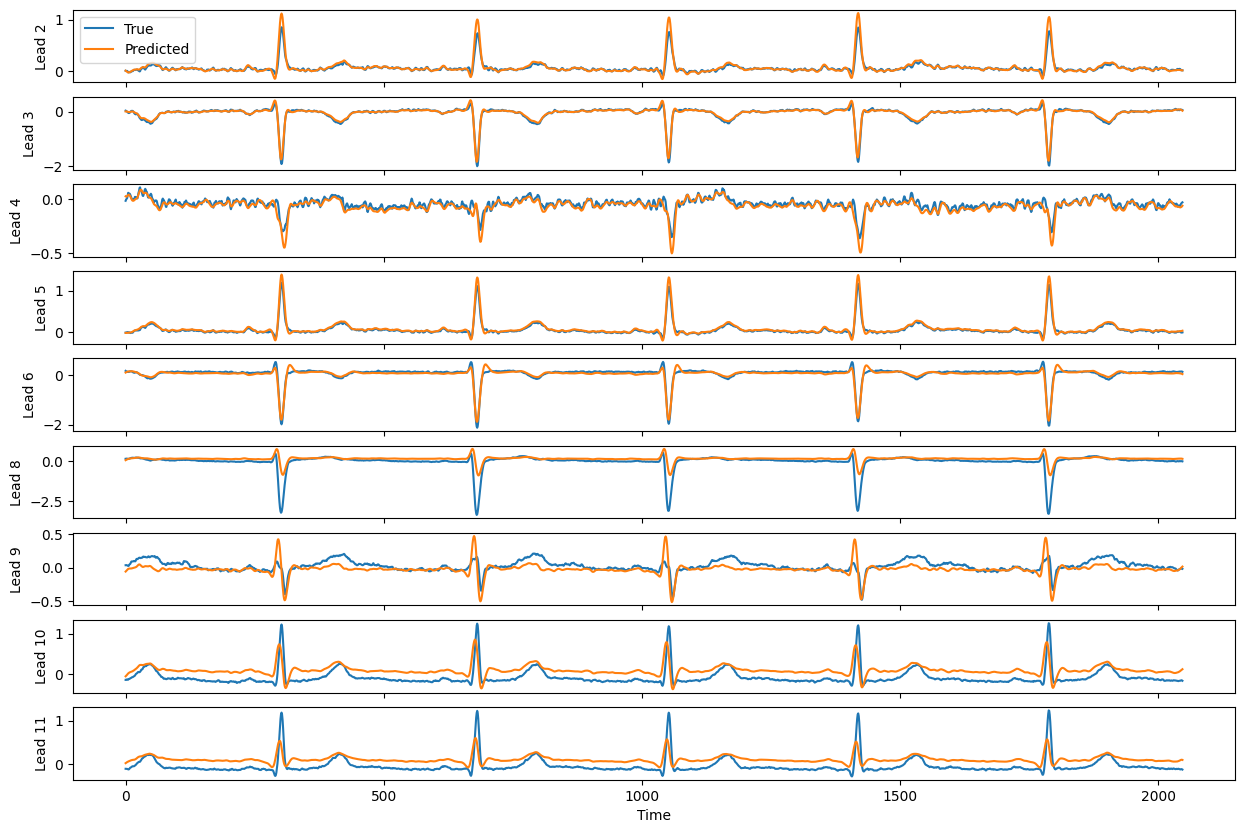

In [20]:
# Evaluate model
val_loss, val_mae = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation MAE: {val_mae:.4f}')

# Predict and plot results for samples
def plot_predictions(generator, model, num_samples=20):
    num_batches = len(generator)
    samples_plotted = 0

    for batch_idx in range(num_batches):
        if samples_plotted >= num_samples:
            break

        X, y = generator[batch_idx]
        y_pred = model.predict(X)

        for sample_idx in range(len(X)):
            if samples_plotted >= num_samples:
                break

            fig, axs = plt.subplots(len(output_leads), 1, figsize=(15, 10), sharex=True)
            for k, ax in enumerate(axs):
                ax.plot(y[sample_idx, :, k], label='True')
                ax.plot(y_pred[sample_idx, :, k], label='Predicted')
                ax.set_ylabel(f'Lead {output_leads[k]}')
                if k == 0:
                    ax.legend()
            plt.xlabel('Time')
            plt.show()
            samples_plotted += 1

plot_predictions(val_generator, model)

2/2 [==============================] - 0s 46ms/step


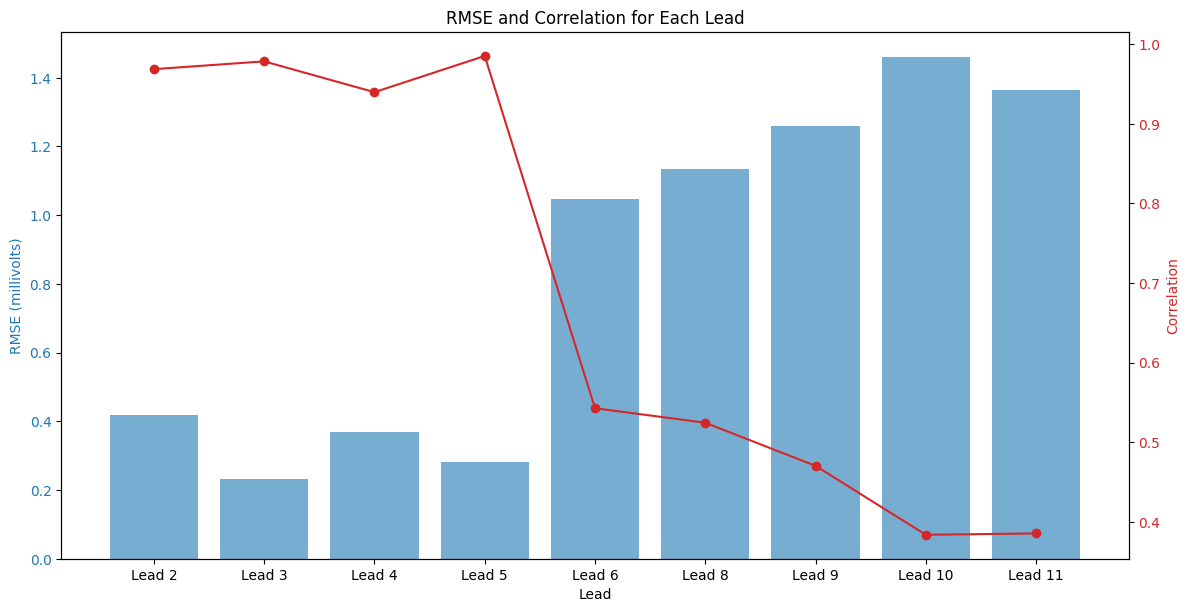

In [25]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Define input and output leads
input_leads = [0, 1, 7]  # DI, DII, V2
output_leads = [2, 3, 4, 5, 6, 8, 9, 10, 11]  # DIII, AVR, AVL, AVF, V1, V3, V4, V5, V6

# Split indices for training and validation
file_path = '/home/balarcon/Documentos/exams_part0.hdf5'
with h5py.File(file_path, 'r') as f:
    total_samples = f['tracings'].shape[0]
indices = np.arange(total_samples)
subset_size = 5000
selected_indices = np.random.choice(indices, subset_size, replace=False)
train_indices, val_indices = train_test_split(selected_indices, test_size=0.2, random_state=42)

# Fit scalers on the training data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

with h5py.File(file_path, 'r') as f:
    dataset = f['tracings']
    X_train = []
    y_train = []
    for idx in train_indices:
        X_train.append(dataset[idx, 1024:3072, input_leads])
        y_train.append(dataset[idx, 1024:3072, output_leads])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

# Reshape and fit scalers
X_train_reshaped = X_train.reshape(-1, len(input_leads))
y_train_reshaped = y_train.reshape(-1, len(output_leads))
scaler_X.fit(X_train_reshaped)
scaler_y.fit(y_train_reshaped)

# Define adjusted HDF5Generator
class HDF5Generator(tf.keras.utils.Sequence):
    def __init__(self, file_path, dataset_name, indices, batch_size, scaler_X=None, scaler_y=None):
        self.file_path = file_path
        self.dataset_name = dataset_name
        self.indices = np.sort(indices)
        self.batch_size = batch_size
        self.num_samples = len(indices)
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, self.num_samples)
        batch_indices = self.indices[batch_start:batch_end]

        with h5py.File(self.file_path, 'r') as f:
            dataset = f[self.dataset_name]
            batch_X = [dataset[idx, 1024:3072, input_leads] for idx in batch_indices]
            batch_y = [dataset[idx, 1024:3072, output_leads] for idx in batch_indices]

        batch_X = np.array(batch_X)
        batch_y = np.array(batch_y)

        if self.scaler_X and self.scaler_y:
            batch_X = self.scaler_X.transform(batch_X.reshape(-1, len(input_leads))).reshape(batch_X.shape)
            batch_y = self.scaler_y.transform(batch_y.reshape(-1, len(output_leads))).reshape(batch_y.shape)

        return batch_X, batch_y

# Function to evaluate model and compute unnormalized RMSE and correlation
def evaluate_model(generator, model, scaler_y):
    all_true = []
    all_pred = []
    for i in range(len(generator)):
        X, y_true = generator[i]
        y_pred = model.predict(X)
        all_true.append(y_true)
        all_pred.append(y_pred)
    
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    
    # Inverse transform to get unnormalized values
    all_true_unnorm = scaler_y.inverse_transform(all_true.reshape(-1, len(output_leads))).reshape(all_true.shape)
    all_pred_unnorm = scaler_y.inverse_transform(all_pred.reshape(-1, len(output_leads))).reshape(all_pred.shape)
    
    rmse = []
    correlations = []
    for k in range(len(output_leads)):
        lead_true = all_true_unnorm[:, :, k].flatten()
        lead_pred = all_pred_unnorm[:, :, k].flatten()
        rmse.append(np.sqrt(mean_squared_error(lead_true, lead_pred)))
        correlations.append(pearsonr(lead_true, lead_pred)[0])
    
    return rmse, correlations

def plot_metrics(rmse, correlations):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Lead')
    ax1.set_ylabel('RMSE (millivolts)', color=color)
    ax1.bar(range(len(output_leads)), rmse, color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(range(len(output_leads)))
    ax1.set_xticklabels([f'Lead {lead}' for lead in output_leads])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Correlation', color=color)
    ax2.plot(range(len(output_leads)), correlations, color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('RMSE and Correlation for Each Lead')
    plt.show()

# Initialize generators with scalers
train_generator = HDF5Generator(file_path, 'tracings', train_indices, batch_size, scaler_X, scaler_y)
val_generator = HDF5Generator(file_path, 'tracings', val_indices, batch_size, scaler_X, scaler_y)

# Evaluate model and plot the metrics
rmse, correlations = evaluate_model(val_generator, model, scaler_y)
plot_metrics(rmse, correlations)
